In [1]:
import shapely.wkt as sw
import shapely
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import collections
import os.path
from tensorflow.keras.utils import to_categorical
import copy

In [2]:
def calc_format(polygon):
    vertices = polygon.exterior.coords[:-1]
    langles = []
    n = len(vertices)
    v1 = (vertices[1][0] - vertices[0][0], vertices[1][1] - vertices[0][1])
    v2 = (vertices[-1][0] - vertices[0][0], vertices[-1][1] - vertices[0][1])
    angle = math.atan2(v2[1],v2[0]) - math.atan2(v1[1],v1[0]);
    langles.append(angle)
    for i in range(1,n-1):
        v1 = (vertices[i+1][0] - vertices[i][0], vertices[i+1][1] - vertices[i][1])
        v2 = (vertices[i-1][0] - vertices[i][0], vertices[i-1][1] - vertices[i][1])
        angle = math.atan2(v2[1],v2[0]) - math.atan2(v1[1],v1[0]);
        langles.append(angle)
    v1 = (vertices[0][0] - vertices[n-1][0], vertices[0][1] - vertices[n-1][1])
    v2 = (vertices[n-2][0] - vertices[n-1][0], vertices[n-2][1] - vertices[n-1][1])
    angle = math.atan2(v2[1],v2[0]) - math.atan2(v1[1],v1[0]);
    langles.append(angle)
    langles = [x+2*math.pi if x<0 else x for x in langles]
    # angles in degrees
    dlangles = [angle*180/math.pi for angle in langles]
    
    # TODO: optimize, maybe return full length (big triangle - building, small triangle - noise)
    ledges = []
    for i in range(1,n):
        l = math.sqrt((vertices[i][0] - vertices[i-1][0])**2 + (vertices[i][1] - vertices[i-1][1])**2)
        ledges.append(l)
    l = math.sqrt((vertices[0][0] - vertices[n-1][0])**2 + (vertices[0][1] - vertices[n-1][1])**2)
    ledges.append(l)
    # scaled
    C = sum(ledges)
    sledges = [edge/C for edge in ledges]
    if len(ledges) != len(langles):
        raise Exception("Wrong number of components, bad calculation!")
    return [langles,sledges]

In [3]:
def angle_edge_format(geometry):
    polygons = []
    for geom in geometry:
        if isinstance(geom, shapely.geometry.multipolygon.MultiPolygon):
            for i in range(len(geom)):
                polygons.append(calc_format(geom[i]))
            # uncomment if intented to group multipolygons
            # multi = []
            # for i in range(len(geom)):
            #     multi.append(calc_format(geom[i]))
            # polygons.append(multi)
            #print("1 - {}".format(np.array(multi).shape))
        else:
            polygons.append(calc_format(geom))
            # uncomment if intented to group multipolygons
            # polygons.append([calc_format(geom)])
            #print("2 - {}".format(np.array([calc_format(geom)]).shape))
    return polygons

In [4]:
def test_dim(testlist, dim=0):
   if isinstance(testlist, list):
      if testlist == []:
          return dim
      dim = dim + 1
      dim = test_dim(testlist[0], dim)
      return dim
   else:
      if dim == 0:
          return -1
      else:
          return dim

In [5]:
def fix_single_class(X, edgeno):
    '''
    
    :param X: polygon list 
    :param edgeno: number of edges for each polygon
    :return: polygon list with appended edge number columng suitable for stratification
    '''
    # conv A to list<string> to become hashable
    ahash = [str(a[0]) for a in edgeno.tolist()]
    # make hashable
    count = collections.Counter(ahash)
    # sorted key list
    scount = [int(a) for a in sorted(count, key=lambda x : int(x))]
    
    for i in range(len(edgeno)):
        #print(count[str(A[i,0])])
        if count[str(edgeno[i,0])] == 1:
            nscount = len(scount)
            # print(A[i,0])
            si = scount.index(edgeno[i,0])
            if si == 0:
                count[str(scount[1])] += 1
                edgeno[i,0] = scount[1]
            elif si == nscount-1:
                count[str(scount[-2])] += 1
                edgeno[i,0] = scount[-2]
            elif abs(si - scount[si-1]) <= abs(si - scount[si+1]):
                count[str(scount[si-1])] += 1
                edgeno[i,0] = scount[si-1]
            else:
                count[str(scount[si+1])] += 1
                edgeno[i,0] = scount[si+1]
            count.pop(str(scount[si]))
            scount.pop(si)
            nscount-=1
            # print(A[i,0], A[i])
            # print('------')
    
    return np.hstack((X,edgeno))
    # Debugging
    # print(f'In f: {X.shape}')
    # nahash = [str(a[0]) for a in A.tolist()]
    # ncount = collections.Counter(nahash)
    # print(ncount)
    # print(poly)

In [6]:
def draw_hist(list, num_bins=100, color='red', xlabel='', ylabel=''):
    '''
    
    :param list: number list of shape (n, 1)
    :param num_bins: number of bins for histogram
    :param color: histogram color
    :param xlabel: x axis label
    :param ylabel: y axis label
    :return: void
    '''
    n, bins, patches = plt.hist(list, num_bins, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [7]:
# reading data from file
geometry = []
label = []

with open('../data/shape_set.tsv', 'r') as f:
    # i = 0
    for line in f:
        pol, lbl = line.rstrip().split('\t')
        geometry.append(sw.loads(pol))
        label.append(0 if lbl == 'bad' else 1)
        # i+=1
        # if i == 30000:
        #     break
    
print(f'Number of polygons {len(geometry)}')    

Number of polygons 20000


In [8]:
# test angle_edge correctness
n_check = []
for i in range(len(geometry)):
    n_check.append(len(geometry[i].exterior.coords[:-1]))

In [9]:
# making numpy feature and label array
polygons = angle_edge_format(geometry)
poly = np.array(polygons)
lbl = np.array(label)

In [10]:
assert len(n_check) == len(polygons), 'Edges numer of POLYGONS doesn\'t match!'
for i in range(len(polygons)):
    assert len(polygons[i][0]) == len(polygons[i][1]), 'Angle and edge numers don\'t match!'
    assert len(polygons[i][0]) == n_check[i], 'Angle numers don\'t match!'

In [11]:
# extracting angles and their min, max
angles = np.hstack(poly[:,0])
min_angle = np.min(angles)
max_angle = np.max(angles)
print("Min angle: {} rad {} deg \n Max angle: {} rad {} deg".format(min_angle, min_angle*180/math.pi, max_angle, max_angle*180/math.pi))

Min angle: 0.0 rad 0.0 deg 
 Max angle: 6.2822123274050625 rad 359.94425236536824 deg


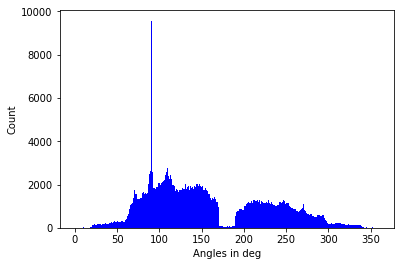

In [12]:
# angle distribution histogram
draw_hist(angles*180/math.pi,360,'blue','Angles in deg','Count')

In [13]:
# add number of edges column
n_edge = np.array([len(p) for p in poly[:,0]])
n_edge = n_edge.reshape((n_edge.shape[0],1))
poly = np.hstack((poly,n_edge))

(20000, 1)


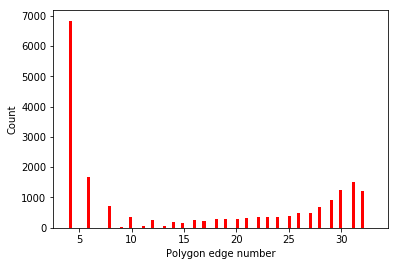

In [14]:
# histogram of number of edges
strat_edgeno = poly[:,2].copy()
strat_edgeno = strat_edgeno.reshape(-1, 1)
print(strat_edgeno.shape)
draw_hist(strat_edgeno,num_bins=100,color='red',xlabel='Polygon edge number',ylabel='Count')

In [15]:
poly = fix_single_class(poly, strat_edgeno)
#print(f'Out of f: {poly.shape}')

In [16]:
# random labels
# prob = [0.3, 0.7]
# lbl = np.random.choice([0,1], size=(poly.shape[0],1), p=prob)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(poly, lbl, test_size=0.33, stratify=poly[:,3])
print(f'X_Train: {X_train.shape}\nX_test: {X_test.shape}\nytrain: {y_train.shape}\nytest: {y_test.shape}')

X_Train: (13400, 4)
X_test: (6600, 4)
ytrain: (13400,)
ytest: (6600,)


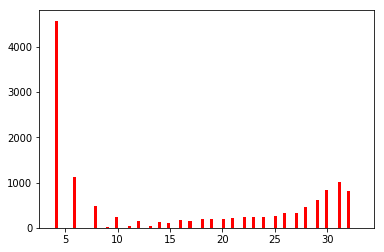

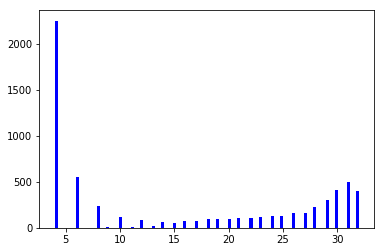

In [18]:
# test stratification
draw_hist(X_train[:,2].reshape(-1,1),100)
draw_hist(X_test[:,2].reshape(-1,1),100,color='blue')

In [19]:
X_train = np.delete(X_train, 3, 1)
X_test = np.delete(X_test, 3, 1)
# Check categorical
Y_train = y_train
Y_test = y_test
#Y_train = to_categorical(y_train, 2)
#Y_test = to_categorical(y_test, 2)
#print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')


In [20]:
# Sort descending by number of angles - prep for batch padding
# TODO: think about removing because of masks usage
argsorted = X_train[:,2].argsort()[::-1]
X_train_sorted = X_train[argsorted]
Y_train_sorted = Y_train[argsorted]
# for i in range(len(X_train)):
#     if i == 32:
#         break
#     print(f'{X_train[i,2]} - {X_train_sorted[i,2]}')

In [21]:
del polygons
del poly
del strat_edgeno
del label
del lbl
del X_train
del y_train
del Y_train

In [22]:
X_train_sorted.shape

(13400, 3)

In [23]:
X_train_list = copy.deepcopy(X_train_sorted[:,:2].tolist())
X_test_list = copy.deepcopy(X_test[:,:2].tolist())
Y_train_list = copy.deepcopy(Y_train_sorted.tolist())
Y_test_list = copy.deepcopy(Y_test.tolist())

In [24]:
#reshape list from (n_samples,channels,features) to (n_samples,features,channels)
for i in range(len(X_train_list)):
    X_train_list[i] = np.array(X_train_list[i]).T.tolist()
for i in range(len(X_test_list)):
    X_test_list[i] = np.array(X_test_list[i]).T.tolist()


In [25]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.losses import sigmoid_cross_entropy

#TODO: Test generator and padding first input with zeroes for training, maybe add first_kernel_size param
#TODO: Add angle number as feature (Konsult sa Mladjom)
#TODO: to_categorical
#TODO: Normalize the data
#TODO: Add masks
#TODO: Maybe shuffle batches before generator

In [46]:
# remove excess deepcopy
class DataGenerator(tf.keras.utils.Sequence):
    'data generator for feeding into memory parts of dataset'
    def __init__(self, dX, dY, batch_size=32, pc_first_kernel_size=None, pad_zeros=True):
        'Initialization'
        self.batch_size = batch_size
        self.dX = copy.deepcopy(dX)
        self.dY = copy.deepcopy(dY)
        self.cyclic_pad = pc_first_kernel_size-1 if pc_first_kernel_size != None else pc_first_kernel_size
        self.zero_pad = pad_zeros
        # self.shuffle = shuffle
        # self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dX) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        # indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        # list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(index)

        return X, Y

    # def on_epoch_end(self):
    #     'Updates indexes after each epoch'
    #     self.indexes = np.arange(len(self.dX))
    #     if self.shuffle == True:
    #         np.random.shuffle(self.indexes)
    
    # Extend with creating mask at the same time
    def pad_zeros(self, xb, longest):
        # x = copy.deepcopy(xb)
        for i in range(len(xb)):
            l = len(xb[i])
            xb[i].extend([[0, 0]]*(longest-l))
        return xb
    
    # shortest poly has 4 edges, and first filter is 5
    def pad_cyclic(self, xb):
        # x = copy.deepcopy(xb)
        for i in range(len(xb)):
            #print(f'Before cyclic: {len(xb[i])}')
            xb[i].extend(xb[i][:self.cyclic_pad])
            #print(f'After cyclic: {len(xb[i])}')
        return xb

    def __data_generation(self, index):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        xb = copy.deepcopy(self.dX[index*self.batch_size:(index+1)*self.batch_size])
        yb = copy.deepcopy(self.dY[index*self.batch_size:(index+1)*self.batch_size])
        if self.cyclic_pad != None:
            self.pad_cyclic(xb)
        if self.zero_pad:
            longest = max(list(map(len, xb)))
            # print(f'Padding to size: {longest}')
            self.pad_zeros(xb, longest)
        # Initialization
        # X = np.empty((self.batch_size, longest, 2))
        # target 2 channels
        # Y = np.empty((self.batch_size, 1))
        # print(f'X shape:{X.shape} Y shape: {Y.shape})')
        X=np.array(xb)
        Y=np.array(yb)
        # print(f'X shape:{X.shape} Y shape: {Y.shape})')
        # print('--------------------------------------')

        return X, Y

In [37]:
def createModel(batch_size=32):
    input = Input(shape = (None,2))
    x = Conv1D(filters=64,kernel_size=3,padding='valid')(input)
    #x = Conv1D(filters=64,kernel_size=5,padding='valid')(x) 
    x = GlobalAveragePooling1D()(x)
    x = Dense(8, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [38]:
#prototype data for creating generator
# x = np.random.randn(32,30,2).tolist()
# x=x+np.random.randn(32,15,2).tolist()
# x=x+np.random.randn(32,17,2).tolist()
# x = np.array(x)
# print(x.shape)
# x=x.tolist()
# prob = [0.3, 0.7]
# y = np.random.choice([0,1], size=(96,1), p=prob).tolist()
# 
# X = np.random.randn(96,10,2)
# Y = np.random.choice([0,1], size=(96,1), p=prob)

In [39]:
train_generator = DataGenerator(X_train_list,Y_train_list,batch_size=64,pc_first_kernel_size=3)

In [40]:
tf.keras.backend.clear_session()

In [41]:
model = createModel()
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 2)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          448       
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit_generator(generator=train_generator,
                    epochs=100,
                    use_multiprocessing=False,
                    workers=0)

Epoch 1/100
209/209 [==============================] - 1s 6ms/step - loss: 0.1565 - acc: 0.9497
Epoch 2/100
209/209 [==============================] - 1s 6ms/step - loss: 1.0044 - acc: 0.6453
Epoch 3/100
209/209 [==============================] - 1s 6ms/step - loss: 0.6212 - acc: 0.7836
Epoch 4/100
209/209 [==============================] - 1s 6ms/step - loss: 0.5858 - acc: 0.8411
Epoch 5/100
209/209 [==============================] - 1s 6ms/step - loss: 0.5538 - acc: 0.8411
Epoch 6/100
209/209 [==============================] - 1s 6ms/step - loss: 0.3815 - acc: 0.8501
Epoch 7/100
209/209 [==============================] - 1s 6ms/step - loss: 0.3585 - acc: 0.8458
Epoch 8/100
209/209 [==============================] - 1s 6ms/step - loss: 0.3071 - acc: 0.9048
Epoch 9/100
209/209 [==============================] - 1s 6ms/step - loss: 0.2778 - acc: 0.8793
Epoch 10/100
209/209 [==============================] - 1s 6ms/step - loss: 0.2509 - acc: 0.9049
Epoch 11/100
209/209 [=================

In [47]:
test_generator = DataGenerator(X_test_list,Y_test_list,batch_size=1)


In [48]:
# print(len(X_train_list[0]))
# print(X_train_list[0])

#TODO: add pad = true attribute to generator
model.evaluate_generator(test_generator)

[0.09351264156482736, 0.97015154]

In [50]:
model.save('cycl_conv3_64_e100.h5')